In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import float32, zeros, ones, eye, as_tensor, tensor

from sbi.inference import MCMCPosterior, VIPosterior, ImportanceSamplingPosterior
from sbi.analysis import pairplot
from sbi.utils import mcmc_transform

from gbi.GBI import GBInference
from gbi.hh.train_gbi import MaeDistZ
import gbi.hh.utils as utils
from gbi.hh.HodgkinHuxley import HodgkinHuxley
from gbi.hh.HodgkinHuxleyStatsMoments import HodgkinHuxleyStatsMoments

/home/michael/anaconda3/envs/gbi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Main figure is with 1 Million simulations

In [4]:
mode = "100K"
use_xo = "use_five"  # use 5 does not use xo but it only uses x with more than 5 spikes

In [5]:
if mode == "1M":
    gbi_path = "/home/michael/Documents/neuralgbi/results/hh/gbi/2023_05_11__20_27_12_m/1_nsims_1000000"
    npe_path = "/home/michael/Documents/neuralgbi/results/hh/npe/2023_05_11__21_45_52_m/1_nsims_1000000"
elif mode == "100K":
    if use_xo == "use":
        gbi_path = "/home/michael/Documents/neuralgbi/results/hh/gbi/2023_05_12__15_58_05"
    elif use_xo == "do_not_use":
        gbi_path = "/home/michael/Documents/neuralgbi/results/hh/gbi/2023_05_11__20_27_12_m/0_nsims_100000"
    elif use_xo == "append":
        gbi_path = "/home/michael/Documents/neuralgbi/results/hh/gbi/2023_05_12__17_45_22"
    elif use_xo == "use_five":
        gbi_path = "/home/michael/Documents/neuralgbi/results/hh/gbi/2023_05_12__20_15_13"
    else:
        raise NameError
    npe_path = "/home/michael/Documents/neuralgbi/results/hh/npe/2023_05_11__21_45_52_m/0_nsims_100000"
else:
    raise NameError

In [6]:
with open(f"{gbi_path}/inference_gbi.pkl", "rb") as handle:
    inference_gbi = pickle.load(handle)
with open(f"{npe_path}/inference_npe.pkl", "rb") as handle:
    inference_npe = pickle.load(handle)

### Load simulator

In [7]:
cols = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
    "#6a3d9a",
]

In [8]:
seed = 1
n_xcorr = 0
n_mom = 4
n_summary = 7

In [43]:
true_params, labels_params = utils.obs_params(reduced_model=False)

list_cells_AllenDB = [518290966, 57, 0.0234 / 126]

ephys_cell = list_cells_AllenDB[0]
sweep_number = list_cells_AllenDB[1]
A_soma = list_cells_AllenDB[2]
junction_potential = -14

obs = utils.allen_obs_data(
    ephys_cell=ephys_cell, sweep_number=sweep_number, A_soma=A_soma
)
obs["data"] = obs["data"] + junction_potential
I = obs["I"]
dt = obs["dt"]
t_on = obs["t_on"]
t_off = obs["t_off"]

sim = HodgkinHuxley(
    I, dt, V0=obs["data"][0], reduced_model=False, cython=True, prior_log=False
)
stats = HodgkinHuxleyStatsMoments(
    t_on=t_on, t_off=t_off, n_xcorr=n_xcorr, n_mom=n_mom, n_summary=n_summary
)

### Load prior

In [10]:
prior = utils.prior(
    true_params=true_params,
    prior_uniform=True,
    prior_extent=True,
    prior_log=False,
    seed=0,
)
limits = torch.stack(
    [
        prior.support.base_constraint.lower_bound,
        prior.support.base_constraint.upper_bound,
    ]
).T

### Generate xo

In [30]:
# Generate 10 simulations for 100 thetas
_ = torch.manual_seed(1)

nsims = 100
theta_vals = prior.sample((nsims,))
seeds = torch.randint(0, 100000, (nsims,))
obs_stats_ls = []
all_obs = []
for theta_ind, theta_val in enumerate(theta_vals):
    x_val = sim.gen_single(theta_val, seed=seeds[theta_ind])
    all_obs.append(x_val)
    summstats = stats.calc([x_val])
    obs_stats_ls.append(summstats)

obs_stats_ls = np.asarray(obs_stats_ls)
obs_stats_ls = torch.as_tensor(obs_stats_ls, dtype=torch.float32)

In [31]:
obs_stats_ls_condition = obs_stats_ls[:, :, 0] > 5.0
obs_stats_ls = obs_stats_ls[obs_stats_ls_condition].unsqueeze(1)

In [12]:
with open("allen_data/allen_theta.pkl", "rb") as handle:
    theta = pickle.load(handle)

with open("allen_data/allen_summstats.pkl", "rb") as handle:
    x = pickle.load(handle)

In [13]:
prior_av_dists = []
for xo in obs_stats_ls:
    dists = inference_gbi.distance_func(x[:1000].unsqueeze(1), xo)
    prior_av_dists.append(torch.mean(dists))

# GBI

In [15]:
with open(f"../../results/hh/notebook/{mode}/01_prior_theta_{use_xo}.pkl", "rb") as handle:
    theta_vals = pickle.load(handle)
with open(f"../../results/hh/notebook/{mode}/01_prior_pred_{use_xo}.pkl", "rb") as handle:
    final_stats = pickle.load(handle)

x_target_vals = torch.as_tensor(obs_stats_ls, dtype=torch.float32)

pred_dists = np.asarray([inference_gbi.predict_distance(theta_vals, x_target_val).detach().numpy() for x_target_val in x_target_vals])
true_dists = np.asarray([inference_gbi.distance_func(final_stats, x_target_val).numpy() for x_target_val in x_target_vals])

### Draw samples from posterior

In [16]:
def sample_gbi_all_xo(beta):
    all_samples = []
    for xo in x_target_vals:
        xo = as_tensor(xo)
        potential_fn = inference_gbi.get_potential(x_o=xo, beta=beta)
        theta_transform = mcmc_transform(prior)

        posterior = MCMCPosterior(
            potential_fn,
            theta_transform=theta_transform,
            proposal=prior,
            method="slice_np_vectorized",
            thin=10,
            warmup_steps=50,
            num_chains=100,
            init_strategy="resample",
            frac_chains_to_finish=0.9,
        )
        posterior_samples = posterior.sample((1_000,), frac_chains_to_finish=0.9)
        all_samples.append(posterior_samples)
    return all_samples

In [17]:
betas = [25.0, 50.0, 100.0]

In [18]:
_ = torch.manual_seed(222)

all_posterior_gbi_samples = {}
for beta in betas:
    samples_gbi = sample_gbi_all_xo(beta)
    all_posterior_gbi_samples[f"beta_{int(beta)}"] = samples_gbi
    
with open(f"../../results/hh/notebook/{mode}/12_posterior_samples_gbi_allen_{use_xo}.pkl", "wb") as handle:
    pickle.dump(all_posterior_gbi_samples, handle)

Running vectorized MCMC with 100 chains:  14%|█████████████▉                                                                                   | 8800/61200 [00:24<01:18, 668.22it/s]
KeyboardInterrupt



In [ ]:
with open(f"../../results/hh/notebook/{mode}/12_posterior_samples_gbi_allen_{use_xo}.pkl", "rb") as handle:
    all_posterior_gbi_samples = pickle.load(handle)

### Posterior predictives

In [ ]:
final_predictive_stats_gbi = {}
final_predictive_traces_gbi = {}
for key in all_posterior_gbi_samples.keys():
    posterior_samples_all_xos = all_posterior_gbi_samples[key]
    all_predictive_stats_gbi = []
    all_predictive_traces_gbi = []
    for posterior_samples in posterior_samples_all_xos:
        r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
        stats_ = stats.calc(r)
        all_predictive_stats_gbi.append(torch.as_tensor(stats_, dtype=torch.float32))
        all_predictive_traces_gbi.append(r)
        
    final_predictive_stats_gbi[key] = all_predictive_stats_gbi
    final_predictive_traces_gbi[key] = all_predictive_traces_gbi

with open(f"../../results/hh/notebook/{mode}/13_posterior_predictive_stats_gbi_allen_{use_xo}.pkl", "wb") as handle:
    pickle.dump(final_predictive_stats_gbi, handle)
with open(f"../../results/hh/notebook/{mode}/13_posterior_predictive_traces_gbi_allen_{use_xo}.pkl", "wb") as handle:
    pickle.dump(final_predictive_traces_gbi, handle)

In [ ]:
with open(f"../../results/hh/notebook/{mode}/13_posterior_predictive_stats_gbi_allen_{use_xo}.pkl", "rb") as handle:
    final_predictive_stats_gbi = pickle.load(handle)
with open(f"../../results/hh/notebook/{mode}/13_posterior_predictive_traces_gbi_allen_{use_xo}.pkl", "rb") as handle:
    final_predictive_traces_gbi = pickle.load(handle)

### Panel A

In [ ]:
time_vec_obs = np.linspace(np.min(sim.t), np.max(sim.t), len(all_obs[0]["data"]))

Running vectorized MCMC with 100 chains:  14%|█████████████▉                                                                                   | 8830/61200 [00:39<01:18, 668.22it/s]

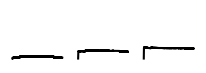

In [79]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(2.4, 0.7))
        
    for i in range(3):
        xo  = all_obs[i]
        _ = ax[i].plot(time_vec_obs, xo["data"], c="k")

        _ = ax[i].set_xlabel("")
        _ = ax[i].set_ylabel("")
        _ = ax[i].set_ylim([-100, 60])
        _ = ax[i].spines["left"].set_visible(False)
        _ = ax[i].spines["bottom"].set_visible(False)
        _ = ax[i].set_xticks([])
        _ = ax[i].set_yticks([])
    plt.savefig("svg/appendix1_panel_a.svg")
    plt.show()

### Evaluate distance estimator on posterior samples

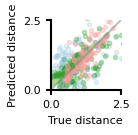

In [80]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.9, 0.9))
    with open("01_prior_theta.pkl", "rb") as handle:
        theta_vals = pickle.load(handle)
    with open("01_prior_pred.pkl", "rb") as handle:
        final_stats = pickle.load(handle)

    x_target_vals = torch.as_tensor(obs_stats_ls, dtype=torch.float32)[:5]

    pred_dists = np.asarray([inference_gbi.predict_distance(theta_vals, x_target_val).detach().numpy() for x_target_val in x_target_vals])
    true_dists = np.asarray([inference_gbi.distance_func(final_stats, x_target_val).numpy() for x_target_val in x_target_vals])
    
    _ = ax.plot([0, 2.5], [0, 2.5], c="grey", alpha=0.5)
    for i in range(5):
        t = true_dists[i]
        p = pred_dists[i]
        _ = ax.scatter(t, p, c=cols[i], alpha=.3)
        ax.set_xticks([0, 2.5])
        ax.set_yticks([0, 2.5])

    ax.set_xlim([0, 2.5])
    ax.set_ylim([0, 2.5])
    ax.set_xlabel("True distance")
    ax.set_ylabel("Predicted distance")
    
    plt.savefig("svg/appendix1_panel_b.svg")

### Panel D

In [81]:
all_gbi_distances = []
for key in final_predictive_stats_gbi.keys():
    pred_stats = final_predictive_stats_gbi[key]
    gbi_av_dists = []
    for predictives, xo in zip(pred_stats, obs_stats_ls):
        dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
        gbi_av_dists.append(torch.mean(dists))
    all_gbi_distances.append(gbi_av_dists)

In [82]:
time_vec_obs = np.linspace(np.min(sim.t), np.max(sim.t), len(all_obs[0]["data"]))

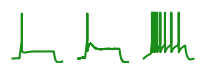

In [83]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(2.4, 0.7))
        
    for i in range(3):
        predictive = final_predictive_traces_gbi["beta_300"][i][0]
        _ = ax[i].plot(sim.t, predictive["data"], c="green", alpha=0.9)

        _ = ax[i].set_xlabel("")
        _ = ax[i].set_ylabel("")
        _ = ax[i].set_ylim([-100, 60])
        _ = ax[i].spines["left"].set_visible(False)
        _ = ax[i].spines["bottom"].set_visible(False)
        _ = ax[i].set_xticks([])
        _ = ax[i].set_yticks([])
    plt.savefig("svg/appendix1_panel_d1.svg")
    plt.show()

### Panel C

In [84]:
_ = torch.manual_seed(2222)

npe_all_samples = []
maps = []
for xo in obs_stats_ls:
    xo = as_tensor(xo)
    posterior = inference_npe.build_posterior()
    posterior_samples = posterior.sample((1_000,), x=xo)
    npe_all_samples.append(posterior_samples)

Drawing 1000 posterior samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 40834.39it/s]


/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(


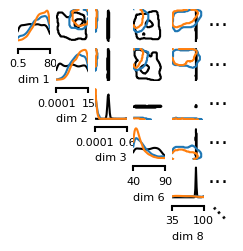

In [85]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = pairplot(
        [
            npe_all_samples[0], 
            all_posterior_gbi_samples["beta_25"][0], 
            all_posterior_gbi_samples["beta_80"][0], 
        ],
        limits=limits,
        ticks=limits,
        upper="contour",
        contour_offdiag={"levels": [0.68], "percentile": True},
        figsize=(2.4, 2.4),
        diag="kde",
        subset=[0, 1, 2, 5, 7]
    )
    plt.savefig("svg/appendix1_panel_c.svg")

### Panel D2

In [86]:
_ = torch.manual_seed(3333)

all_predictive_traces = []
all_predictive_stats = []
for posterior_samples in npe_all_samples:
    r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
    all_predictive_traces.append(r)
    stats_ = stats.calc(r)
    all_predictive_stats.append(torch.as_tensor(stats_, dtype=torch.float32))

with open(f"../../results/hh/notebook/{mode}/14_npe_theta_amo.pkl", "wb") as handle:
    pickle.dump(npe_all_samples, handle)
with open(f"../../results/hh/notebook/{mode}/14_npe_stats_amo.pkl", "wb") as handle:
    pickle.dump(all_predictive_stats, handle)
with open(f"../../results/hh/notebook/{mode}/14_npe_traces_amo.pkl", "wb") as handle:
    pickle.dump(all_predictive_traces, handle)

In [87]:
with open(f"../../results/hh/notebook/{mode}/14_npe_theta_amo.pkl", "rb") as handle:
    npe_all_samples = pickle.load(handle)
with open(f"../../results/hh/notebook/{mode}/14_npe_stats_amo.pkl", "rb") as handle:
    all_predictive_stats = pickle.load(handle)
with open(f"../../results/hh/notebook/{mode}/14_npe_traces_amo.pkl", "rb") as handle:
    all_predictive_traces = pickle.load(handle)

In [88]:
npe_av_dists = []
for predictives, xo in zip(all_predictive_stats, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    npe_av_dists.append(torch.mean(dists))

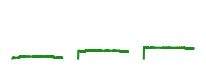

In [89]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(2.4, 0.7))
        
    for i in range(3):
        predictive = all_predictive_traces[i][5]
        _ = ax[i].plot(sim.t, predictive["data"], c="green", alpha=0.9)

        _ = ax[i].set_xlabel("")
        _ = ax[i].set_ylabel("")
        _ = ax[i].set_ylim([-100, 60])
        _ = ax[i].spines["left"].set_visible(False)
        _ = ax[i].spines["bottom"].set_visible(False)
        _ = ax[i].set_xticks([])
        _ = ax[i].set_yticks([])
    plt.savefig("svg/appendix1_panel_d2.svg")
    plt.show()

### Panel E

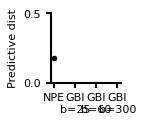

In [90]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.9, 0.9))
    _ = ax.scatter([0], [np.mean(npe_av_dists)], c="k")
    _ = ax.plot([1, 2, 3], [np.mean(dist) for dist in all_gbi_distances])
    _ = ax.scatter([1, 2, 3], [np.mean(dist) for dist in all_gbi_distances], s=15)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(["NPE", "GBI\nb=25", "GBI\nb=60", "GBI\nb=300"])
    ax.set_ylabel("Predictive dist")
    ax.set_yticks([0, 0.5])
    ax.set_ylim([0, 0.5])
    plt.savefig("svg/appendix1_panel_e.svg")

### Assemble figure

In [56]:
import time
import IPython.display as IPd
from svgutils.compose import *

In [58]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("15.2cm", "6.1cm",
    
    Panel(
          SVG("svg/appendix1_panel_a.svg").scale(svg_scale),
          Text("a", -5, 15.0, **kwargs_text),
    ).move(10, 0),
           
    Panel(
          SVG("svg/appendix1_panel_b.svg").scale(svg_scale),
          Text("b", -5, 10.0, **kwargs_text),
    ).move(220, 5),
    
    Panel(
          SVG("svg/appendix1_panel_c.svg").scale(svg_scale),
          Text("c", -5, 15.0, **kwargs_text),
    ).move(350, 0),
           
    Panel(
          SVG("svg/appendix1_panel_d1.svg").scale(svg_scale),
          Text("d", -5, 2.0, **kwargs_text),
    ).move(10, 90),
    Panel(
          SVG("svg/appendix1_panel_d2.svg").scale(svg_scale),
    ).move(10, 160),
           
    Panel(
          SVG("svg/appendix1_panel_e.svg").scale(svg_scale),
          Text("e", -5, 2.0, **kwargs_text),
    ).move(220, 120),
)

!mkdir -p fig
f.save("fig/fig_allen.svg")
svg("fig/fig_allen.svg")